Imports

In [ ]:
# In Google Colab
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms
from torchvision import datasets, transforms
from PIL import Image
import matplotlib.pyplot as plt


# Mount Google Drive and load some images
# Display 10 real vs 10 AI images
# Calculate basic stats (image sizes, etc.)

Loading the data

In [ ]:
from datasets import load_dataset

ds = load_dataset("Hemg/AI-Generated-vs-Real-Images-Datasets")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/590 [00:00<?, ?B/s]

data/train-00000-of-00006-336b26d54a26e1(…):   0%|          | 0.00/91.2M [00:00<?, ?B/s]

data/train-00001-of-00006-8ad2d550254dea(…):   0%|          | 0.00/25.9M [00:00<?, ?B/s]

data/train-00002-of-00006-ac8970f21c0418(…):   0%|          | 0.00/339M [00:00<?, ?B/s]

data/train-00003-of-00006-f635132ef309a7(…):   0%|          | 0.00/311M [00:00<?, ?B/s]

data/train-00004-of-00006-1101eaf5152e1c(…):   0%|          | 0.00/40.5M [00:00<?, ?B/s]

data/train-00005-of-00006-4bd152a5ab76db(…):   0%|          | 0.00/565M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/152710 [00:00<?, ? examples/s]

Now that the dataset is loaded, to work on the feature

In [ ]:
#how many images are in this data?

print(len(ds['train']))
# there are 152710 images

152710


uhhhh now what?

to look at the data I think?

bet

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=880x440 at 0x7B97EC1917C0>, 'label': 0}
['train']
first image?:  <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=880x440 at 0x7B97EEFB3E00>


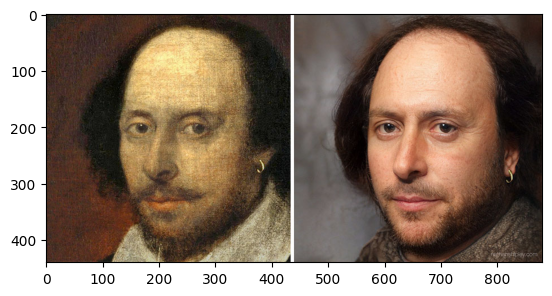

train
['image', 'label']
first label:  0
number of images per labl:  Counter({0: 81174, 1: 71536})


In [ ]:
from polars import count
from typing import KeysView
from collections import Counter
#let's try and bring out the very first image in the data

print(ds['train'][0])
#interesting? this doesn't bring the image itself but brings out its metadata
#this returns {'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=880x440 at 0x7D0DD45AB890>, 'label': 0}

keys = list(ds.keys())
print(keys)
#it returns "train"

#Now to actually display the first image
first_image = ds['train'][0]['image']
print("first image?: ", first_image)

#Matplotlib SAVE MEEEE!!!!!!
plt.imshow(first_image)
plt.show()
# With this treasure I summon the first image, now who the hell is that?? LOL

for key in ds:
  print (key)

example_keys = ds['train'][0].keys()
print(list(example_keys))
# hmm.. this returns ['image', 'label']
#what if I want to print the number of labels in the dataset

num_labels = ds['train'][0]['label']
print("first label: ", num_labels)
#this return 0, why? does it perhaps print the first image's label value?

# YOOO I GET TO USE A HASHMAP??? FOR REAL?? NO WAY?????
count_labels = Counter(ds['train']['label'])
print("number of images per labl: ", count_labels)
# Counter({0: 81174, 1: 71536})

# Dataset labels:
# 0 = AI-generated images
# 1 = Real images

visualization with Maptplotlib

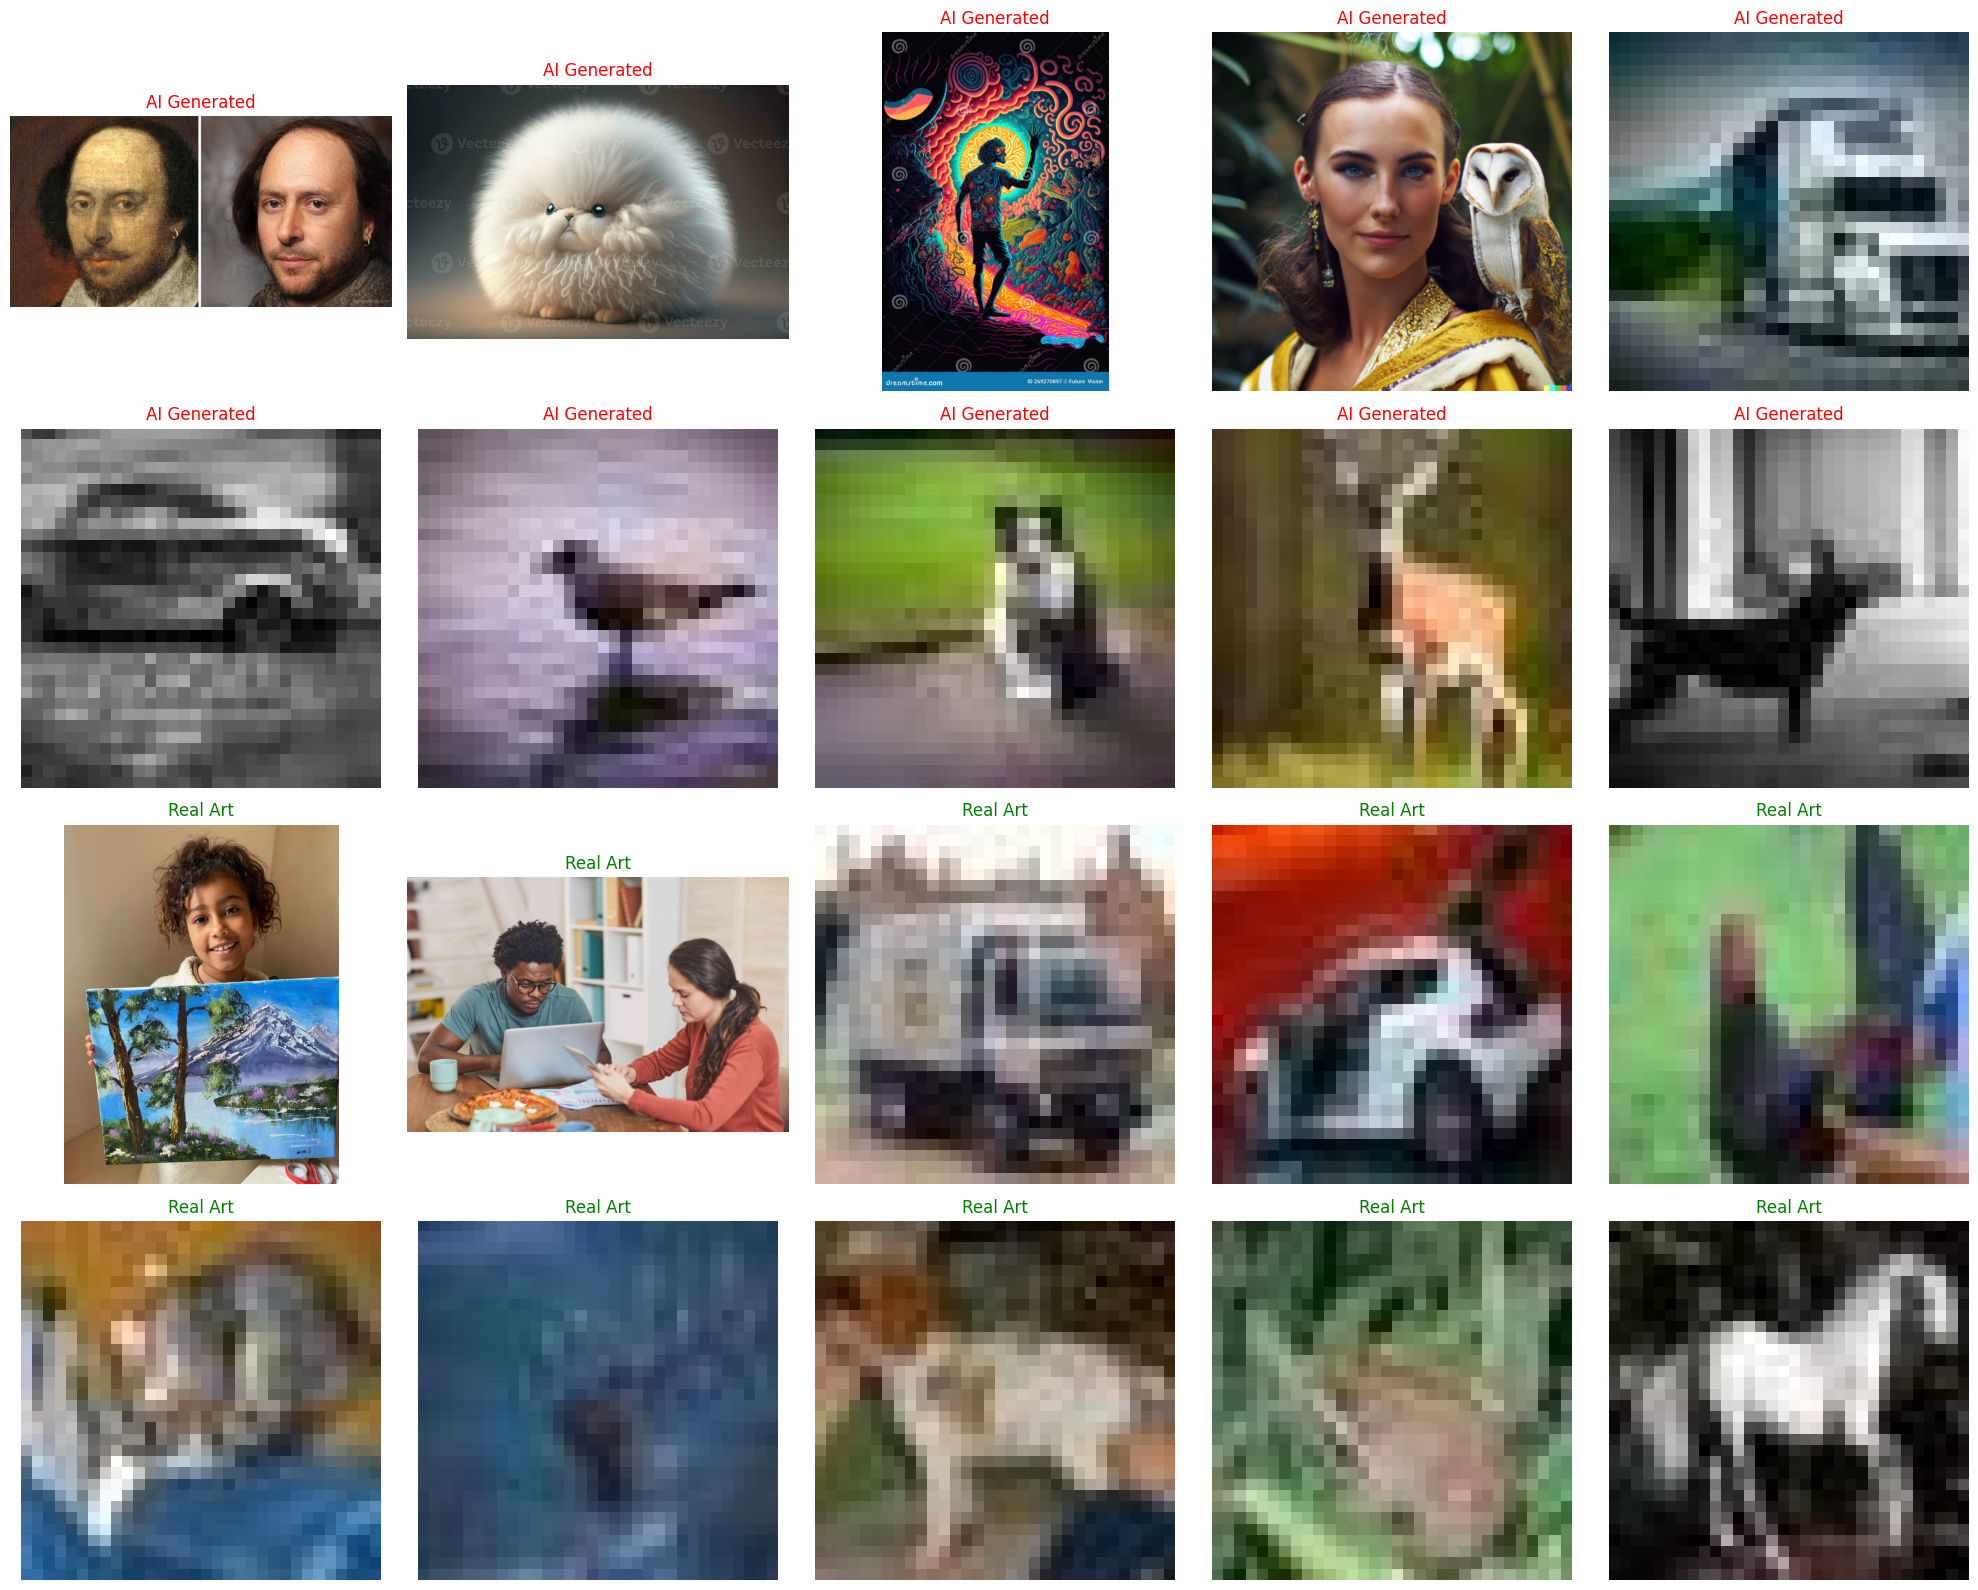

In [ ]:
import matplotlib.pyplot as plt

# Create lists to store images
ai_images = []
real_images = []

# Collect 10 of each
for example in ds['train']:
    if example['label'] == 0 and len(ai_images) < 10:
        ai_images.append(example['image'])
    elif example['label'] == 1 and len(real_images) < 10:
        real_images.append(example['image'])

    # Stop once we have enough
    if len(ai_images) == 10 and len(real_images) == 10:
        break

# Create a 4x5 grid (20 images total)
fig, axes = plt.subplots(4, 5, figsize=(20, 16))

# Display AI images in first two rows
for i in range(10):
    row = i // 5
    col = i % 5
    axes[row, col].imshow(ai_images[i])
    axes[row, col].set_title('AI Generated', fontsize=12, color='red')
    axes[row, col].axis('off')

# Display Real images in last two rows
for i in range(10):
    row = (i // 5) + 2  # Start from row 2
    col = i % 5
    axes[row, col].imshow(real_images[i])
    axes[row, col].set_title('Real Art', fontsize=12, color='green')
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()

Splitting the Dataset

In [ ]:
from torch.utils.data import random_split

# Get total size
total_size = len(ds['train'])

# Calculate split sizes
train_size = int(0.7 * total_size)  # 70%
val_size = int(0.15 * total_size)   # 15%
test_size = total_size - train_size - val_size  # remaining 15%

# Split the dataset
train_dataset, val_dataset, test_dataset = random_split(
    ds['train'],
    [train_size, val_size, test_size]
)

print(f"Training: {len(train_dataset)}")
print(f"Validation: {len(val_dataset)}")
print(f"Test: {len(test_dataset)}")

# Training: 106897
# Validation: 22906
# Test: 22907

Training: 106897
Validation: 22906
Test: 22907


Now to resize the images in the dataset to feed the Model

In [ ]:
from torchvision import transforms

train_transform = transforms.Compose([
    transforms.Lambda(lambda img: img.convert('RGB')),  # NEW LINE
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_test_transform = transforms.Compose([
    transforms.Lambda(lambda img: img.convert('RGB')),  # NEW LINE
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

In [ ]:
import torch
import torch.nn as nn
from torchvision import models

# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Load pre-trained ResNet50
model = models.resnet50(pretrained=True)

# Freeze all layers (we don't want to retrain the whole network)
for param in model.parameters():
    param.requires_grad = False

# Replace the final layer
# ResNet50's final layer is called 'fc' (fully connected)
# Original: 2048 features -> 1000 classes (ImageNet)
# We need: 2048 features -> 2 classes (Real vs AI)
num_features = model.fc.in_features  # This is 2048
model.fc = nn.Linear(num_features, 2)  # Replace with 2 output classes

# Move model to GPU
model = model.to(device)

print("Model loaded and ready!")
print(f"Final layer: {model.fc}")

Using device: cuda
Model loaded and ready!
Final layer: Linear(in_features=2048, out_features=2, bias=True)


Setting up the training

In [ ]:
from torch.utils.data import DataLoader
import torch.optim as optim

# Create DataLoaders - these feed batches of images to the model
batch_size = 32

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Training batches: {len(train_loader)}")
print(f"Validation batches: {len(val_loader)}")
print(f"Test batches: {len(test_loader)}")

# Define loss function
criterion = nn.CrossEntropyLoss()

# Define optimizer - only train the final layer parameters
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)

print("\nTraining setup complete!")

Training batches: 3341
Validation batches: 716
Test batches: 716

Training setup complete!


Now for the actual training loop

In [ ]:
from torch.utils.data import Dataset

class TransformedDataset(Dataset):
    def __init__(self, subset, transform):
        self.subset = subset
        self.transform = transform

    def __len__(self):
        return len(self.subset)

    def __getitem__(self, idx):
        # Get the actual data from the subset
        data = self.subset[idx]

        # Handle both dict format and tuple format
        if isinstance(data, dict):
            image = data['image']
            label = data['label']
        else:
            image, label = data

        # Apply transform
        if self.transform:
            image = self.transform(image)

        return image, label

# Re-wrap your datasets with transforms
train_dataset_transformed = TransformedDataset(train_dataset, train_transform)
val_dataset_transformed = TransformedDataset(val_dataset, val_test_transform)
test_dataset_transformed = TransformedDataset(test_dataset, val_test_transform)

# Re-create DataLoaders with the transformed datasets
train_loader = DataLoader(train_dataset_transformed, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset_transformed, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset_transformed, batch_size=32, shuffle=False)

print("Fixed! DataLoaders recreated with proper transforms")

Fixed! DataLoaders recreated with proper transforms


In [ ]:
# Training function
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=5):
    best_val_acc = 0.0

    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        print("-" * 30)

        # Training phase
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0

        for i, (images, labels) in enumerate(train_loader):
            # Move data to GPU
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Track statistics
            train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()

            # Print progress every 500 batches
            if (i + 1) % 500 == 0:
                print(f"Batch {i+1}/{len(train_loader)}, Loss: {loss.item():.4f}")

        train_acc = 100 * train_correct / train_total
        avg_train_loss = train_loss / len(train_loader)

        # Validation phase
        model.eval()
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for images, labels in val_loader:
                images = images.to(device)
                labels = labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        val_acc = 100 * val_correct / val_total

        print(f"\nTrain Loss: {avg_train_loss:.4f}, Train Acc: {train_acc:.2f}%")
        print(f"Val Acc: {val_acc:.2f}%")

        # Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), 'best_model.pth')
            print(f"✓ Best model saved! (Val Acc: {val_acc:.2f}%)")

    print(f"\nTraining complete! Best validation accuracy: {best_val_acc:.2f}%")

# Start training!
print("Starting training... This will take 1-2 hours")
train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=5)

Starting training... This will take 1-2 hours

Epoch 1/5
------------------------------
Batch 500/3341, Loss: 0.2901
Batch 1000/3341, Loss: 0.5086


/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Batch 1500/3341, Loss: 0.5004
Batch 2000/3341, Loss: 0.4295
Batch 2500/3341, Loss: 0.4353
Batch 3000/3341, Loss: 0.3717

Train Loss: 0.4195, Train Acc: 80.77%
Val Acc: 84.32%
✓ Best model saved! (Val Acc: 84.32%)

Epoch 2/5
------------------------------
Batch 500/3341, Loss: 0.4133
Batch 1000/3341, Loss: 0.2317
Batch 1500/3341, Loss: 0.3354
Batch 2000/3341, Loss: 0.2496
Batch 2500/3341, Loss: 0.3116
Batch 3000/3341, Loss: 0.3892

Train Loss: 0.3851, Train Acc: 82.70%
Val Acc: 85.84%
✓ Best model saved! (Val Acc: 85.84%)

Epoch 3/5
------------------------------
Batch 500/3341, Loss: 0.3012
Batch 1000/3341, Loss: 0.2524
Batch 1500/3341, Loss: 0.2408
Batch 2000/3341, Loss: 0.4189
Batch 2500/3341, Loss: 0.3128
Batch 3000/3341, Loss: 0.4350

Train Loss: 0.3677, Train Acc: 83.50%
Val Acc: 85.10%

Epoch 4/5
------------------------------
Batch 500/3341, Loss: 0.3894
Batch 1000/3341, Loss: 0.3761
Batch 1500/3341, Loss: 0.1641
Batch 2000/3341, Loss: 0.1731
Batch 2500/3341, Loss: 0.4440
Batch 

now to test it

In [ ]:
# Load the best model
model.load_state_dict(torch.load('best_model.pth'))
model.eval()

# Test on test set
test_correct = 0
test_total = 0

print("Testing on test set...")
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

test_acc = 100 * test_correct / test_total
print(f"\n✓ Test Accuracy: {test_acc:.2f}%")
print(f"Correctly classified {test_correct} out of {test_total} images")

Testing on test set...

✓ Test Accuracy: 85.68%
Correctly classified 19627 out of 22907 images


To download the model:

In [ ]:
from google.colab import files
files.download('best_model.pth')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>